## In this notebook, two feature selection methods will be covered: statbility selection and recursive feature elimination (RFE), which are also considered as wrapper methods. Wrapper methods are built on top of other model selection methods such as regression or SVM, building models on different subsets of data and extracting the ranking from the aggregates. 

## Stability selection
Stability selection is a relatively novel method for feature selection, based on subsampling in combination with selection algorithms (which could be regression, SVM or other similar method). The high level idea is to apply a feature selection algorithm on different subsets of data and with different subsets of features. After repeating the process a number of times, the selection results can be aggregated, for example by checking how many times a feature ended up being selected as important when it was in an inspected feature subset. We can expect strong features to have scores close to 100%, since they are always selected when possible. Weaker, but still relevatnt features will also have non-zero scores, since they would be selected when stronger features are not present in the currently selected subset, while irrelevant features would have scores (close to) zero, since they would never be among selected features. 

Python Sklearn implements stability selection in the <font color='blue'>randomized lasso</font> and <font color='blue'>randomized logistic regression </font> classes. In terms of feature selection, there are <font color='red'> well-known limitations</font> of L1-penalized models (LASSO) for regressin and classification. For example, it is known that the LASSO will tend to select an individual variable out of a group of highly correlated features. Furthermore, even when the correlation between features is not too high, the conditions under which L1-penalized methods consistently select "good" features that can be restrictive in general.(: http://scikit-learn.org/stable/modules/feature_selection.html#tree-based-feature-selection) 

In [1]:

from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston
from minepy import MINE
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
boston = load_boston()
print(type(boston))
#using the Boston housing data
#Data get scaled automatically by sklearn's implementation
X = boston['data']
Y = boston['target']
names = boston['feature_names']
print(boston.keys())
print(boston.data.shape)
print(boston.DESCR)


<class 'sklearn.datasets.base.Bunch'>
dict_keys(['data', 'target', 'feature_names', 'DESCR'])
(506, 13)
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        -

In [2]:
rlasso = RandomizedLasso(alpha = 0.025)
rlasso.fit(X,Y)

print("Feature sorted by their score:")
print(sorted(zip(map(lambda x: round(float(x),4), rlasso.scores_),names),reverse=True))


Feature sorted by their score:
[(1.0, 'RM'), (1.0, 'PTRATIO'), (1.0, 'LSTAT'), (0.645, 'B'), (0.635, 'CHAS'), (0.42, 'CRIM'), (0.355, 'TAX'), (0.24, 'NOX'), (0.175, 'INDUS'), (0.175, 'DIS'), (0.065, 'ZN'), (0.03, 'RAD'), (0.015, 'AGE')]


As you can see from the example, the top 3 features have equal scores of 1.0, meaning they were always selected as useful features (of course this could and would change when changing the regularization parameter, but sklearn’s randomized lasso implementation can choose a good α parameter automatically). The scores drop smoothly from there, but in general, the drop off is not sharp as is often the case with pure lasso, or random forest. This means stability selection is useful for both pure feature selection to reduce overfitting, but also for data interpretation: in general, good features won’t get 0 as coefficients just because there are similar, correlated features in the dataset (as is the case with lasso). **For feature selection, it is found to be among the top performing methods for many different datasets and settings.**

## Recursive feature elimination
Recursive feature elimination is based on the idea to repeatedly construct a model (for example an SVM or a regression model) and choose either the best or worst performing feature (for example based on coefficients), setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. Features are then ranked according to when they were eliminated. As such, it is **greedy optimization** for finding the best performing subset of features.

The stability of RFE depends heavily on the type of model that is used for feature ranking at each iteration. Just as no-refularized regression can be unstable, so can RFE when utilizing it, while using **ridge regression can provide more stable resutls.** 

Sklearn provides RFE for recursive feature elimination and RFECV for finding the ranks together with optimal number of features via a cross validation loop. 

In [3]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

boston = load_boston()
X = boston['data']
Y = boston['target']
names = boston['feature_names']

# use linear regression as the model
lr = LinearRegression()
# rank all features, i.e. continue the elimination until the last one
rfe = RFE(lr, n_features_to_select = 1)
rfe.fit(X,Y)

print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x,4),rfe.ranking_),names)))



Features sorted by their rank:
[(1, 'NOX'), (2, 'RM'), (3, 'CHAS'), (4, 'PTRATIO'), (5, 'DIS'), (6, 'LSTAT'), (7, 'RAD'), (8, 'CRIM'), (9, 'INDUS'), (10, 'ZN'), (11, 'TAX'), (12, 'B'), (13, 'AGE')]


## Comparing all the methods side by side

The dataset used in this testcase is called 'Friedman /#1 regression dataset (ref.ftp://ftp.uic.edu/pub/depts/econ/hhstokes/e538/Friedman_mars_1991.pdf). The data is generated using formula $$y = 10 \sin(\pi x_1x_2) + 20(x_3-0.5)^2 + 10 x_4 +5x_5+\epsilon$$ where $x_1$ to $x_5$ are drawn from uniform distribution and $\epsilon$ is the standard normal deviate $N(0,1)$. Additionally, the original dataset had five noise variables $x_6,..,x_{10}$, independent of the response variable. In this case, the noisy variable expands from $x_{11},...,x_{14}$ each of which are very strongly correlated with $x_1,...,x_4$, respectively, generated by $f(x)=x+N(0,0.01))$. This yield a correlation coefficient of more than 0.999 between the variables. This will illustrate how different feature ranking methods deal with correlation in the data. 

In this test, the score will be normalzied between (0,1). For recursive feature elimination, the top five feature will all get score 1 and the rest of the ranks spaced equally between 0 and 1 according to their rank. 

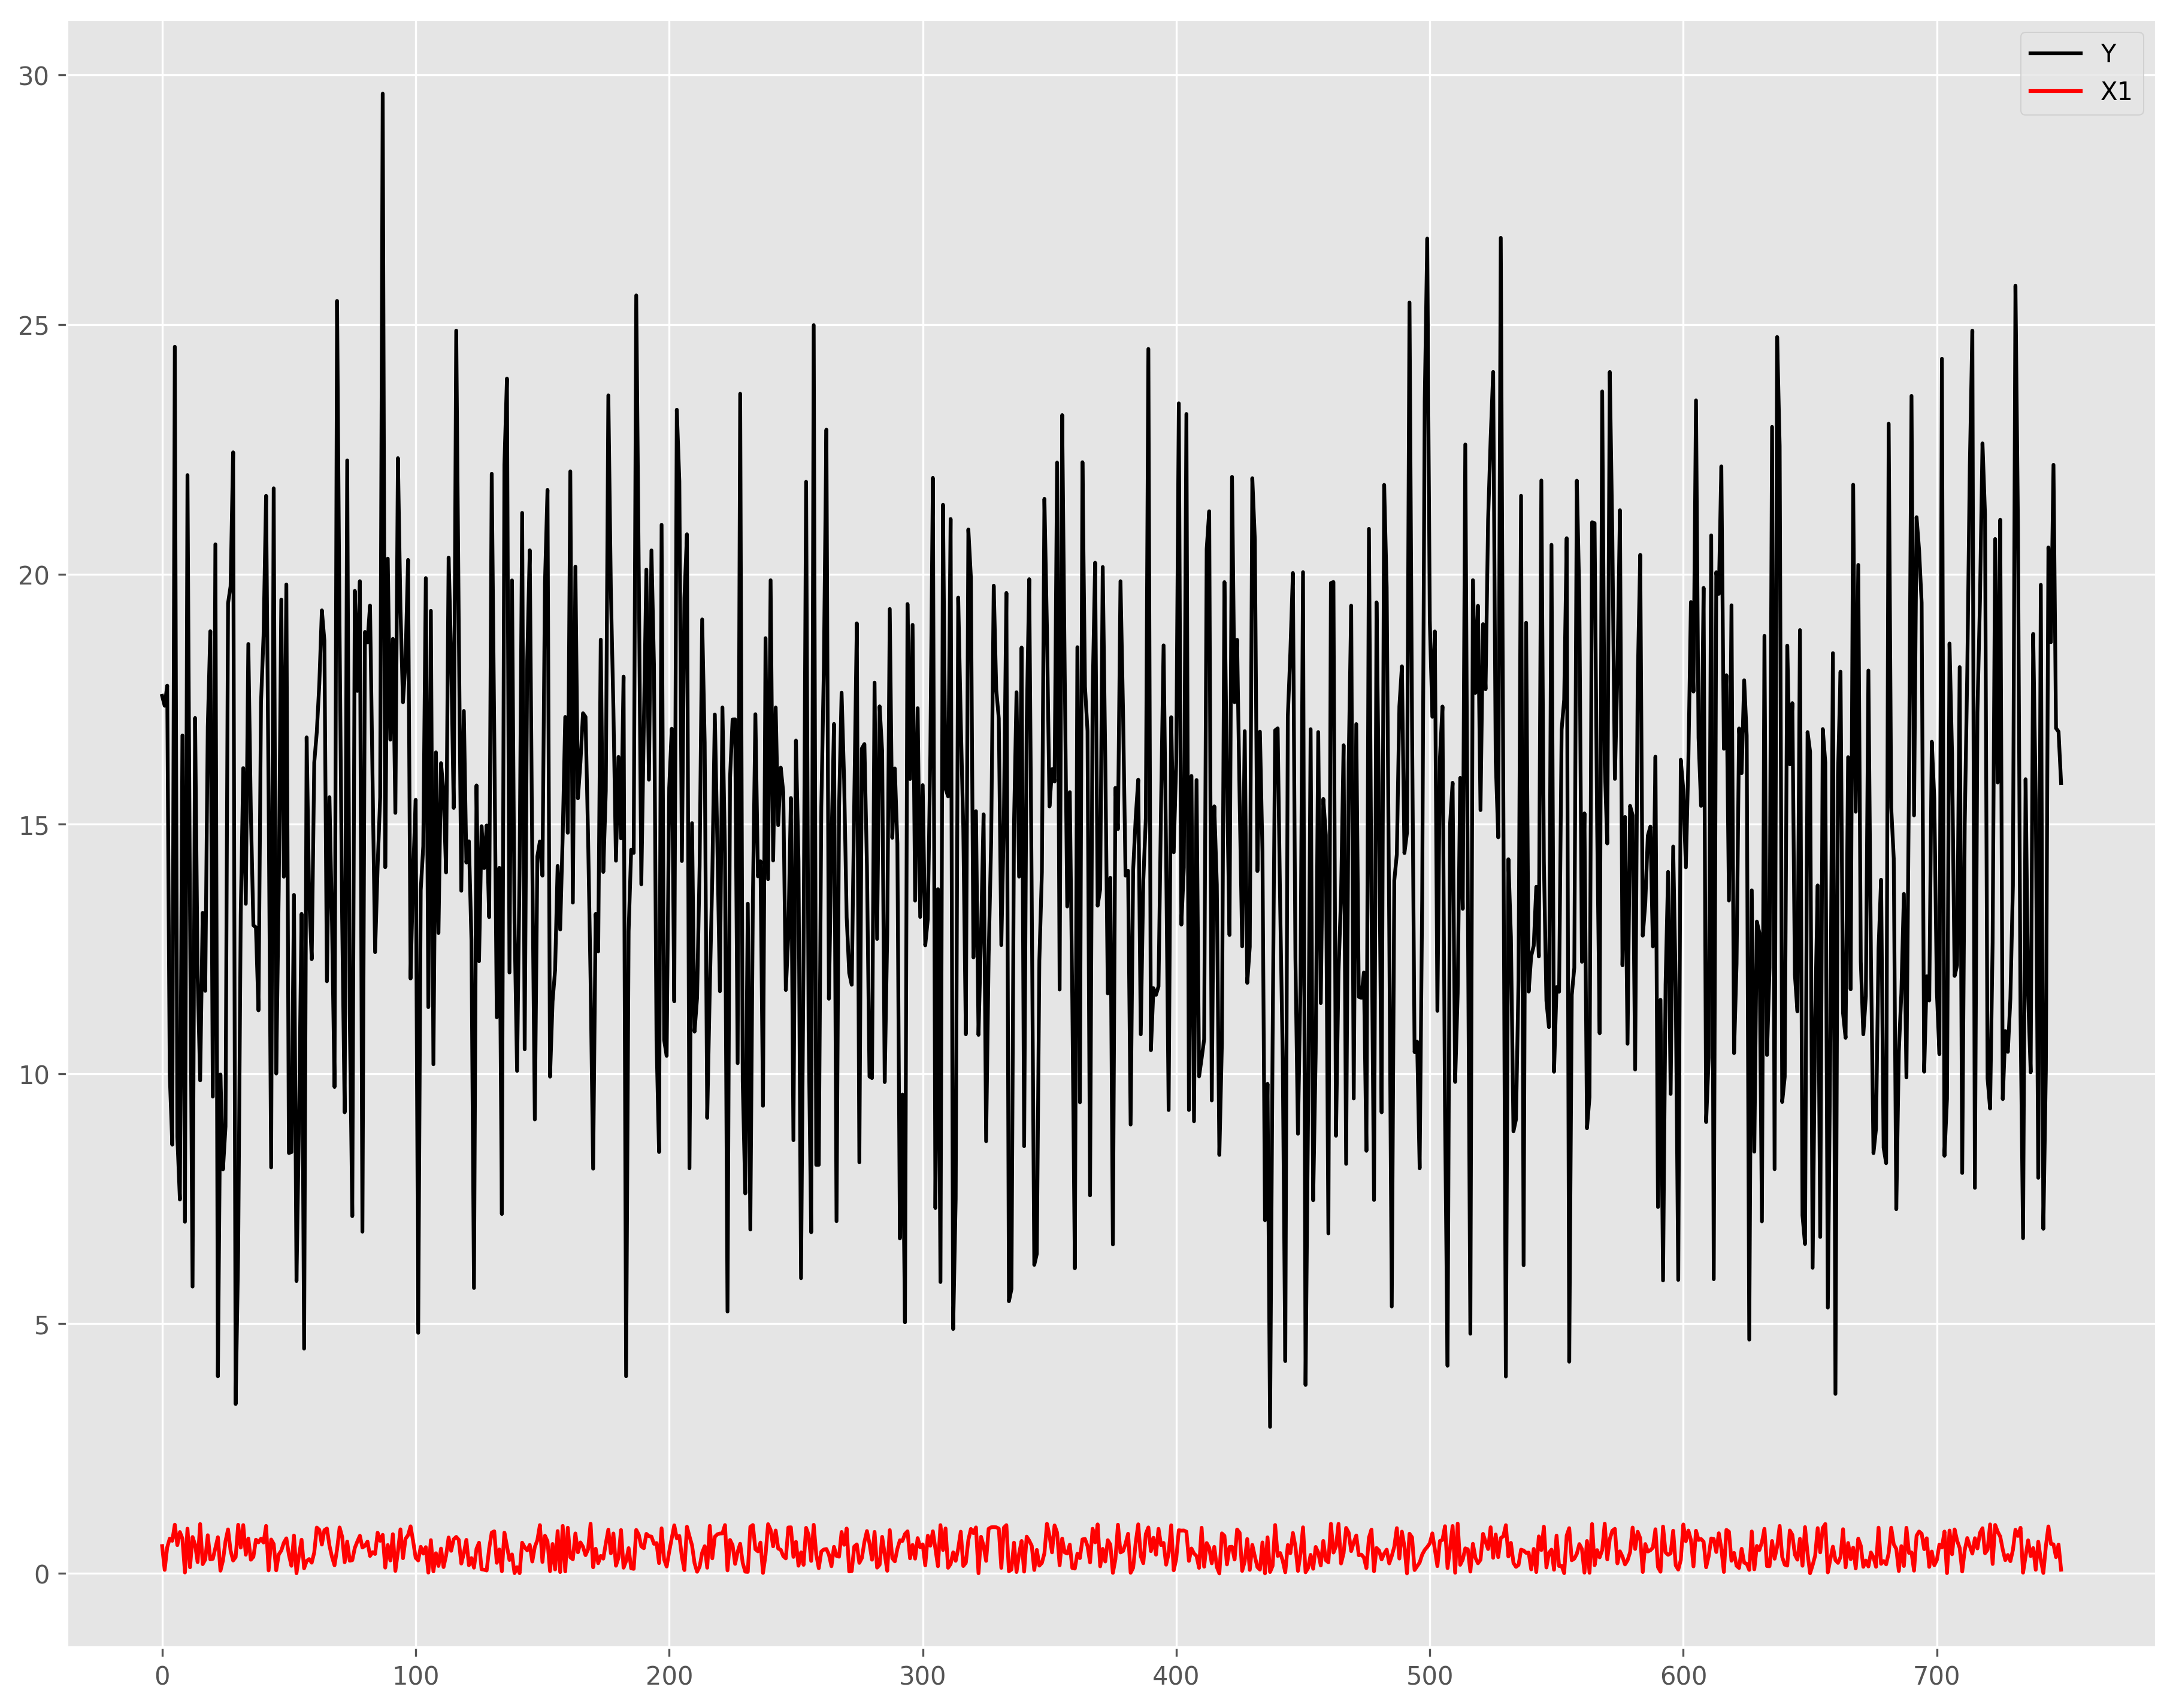

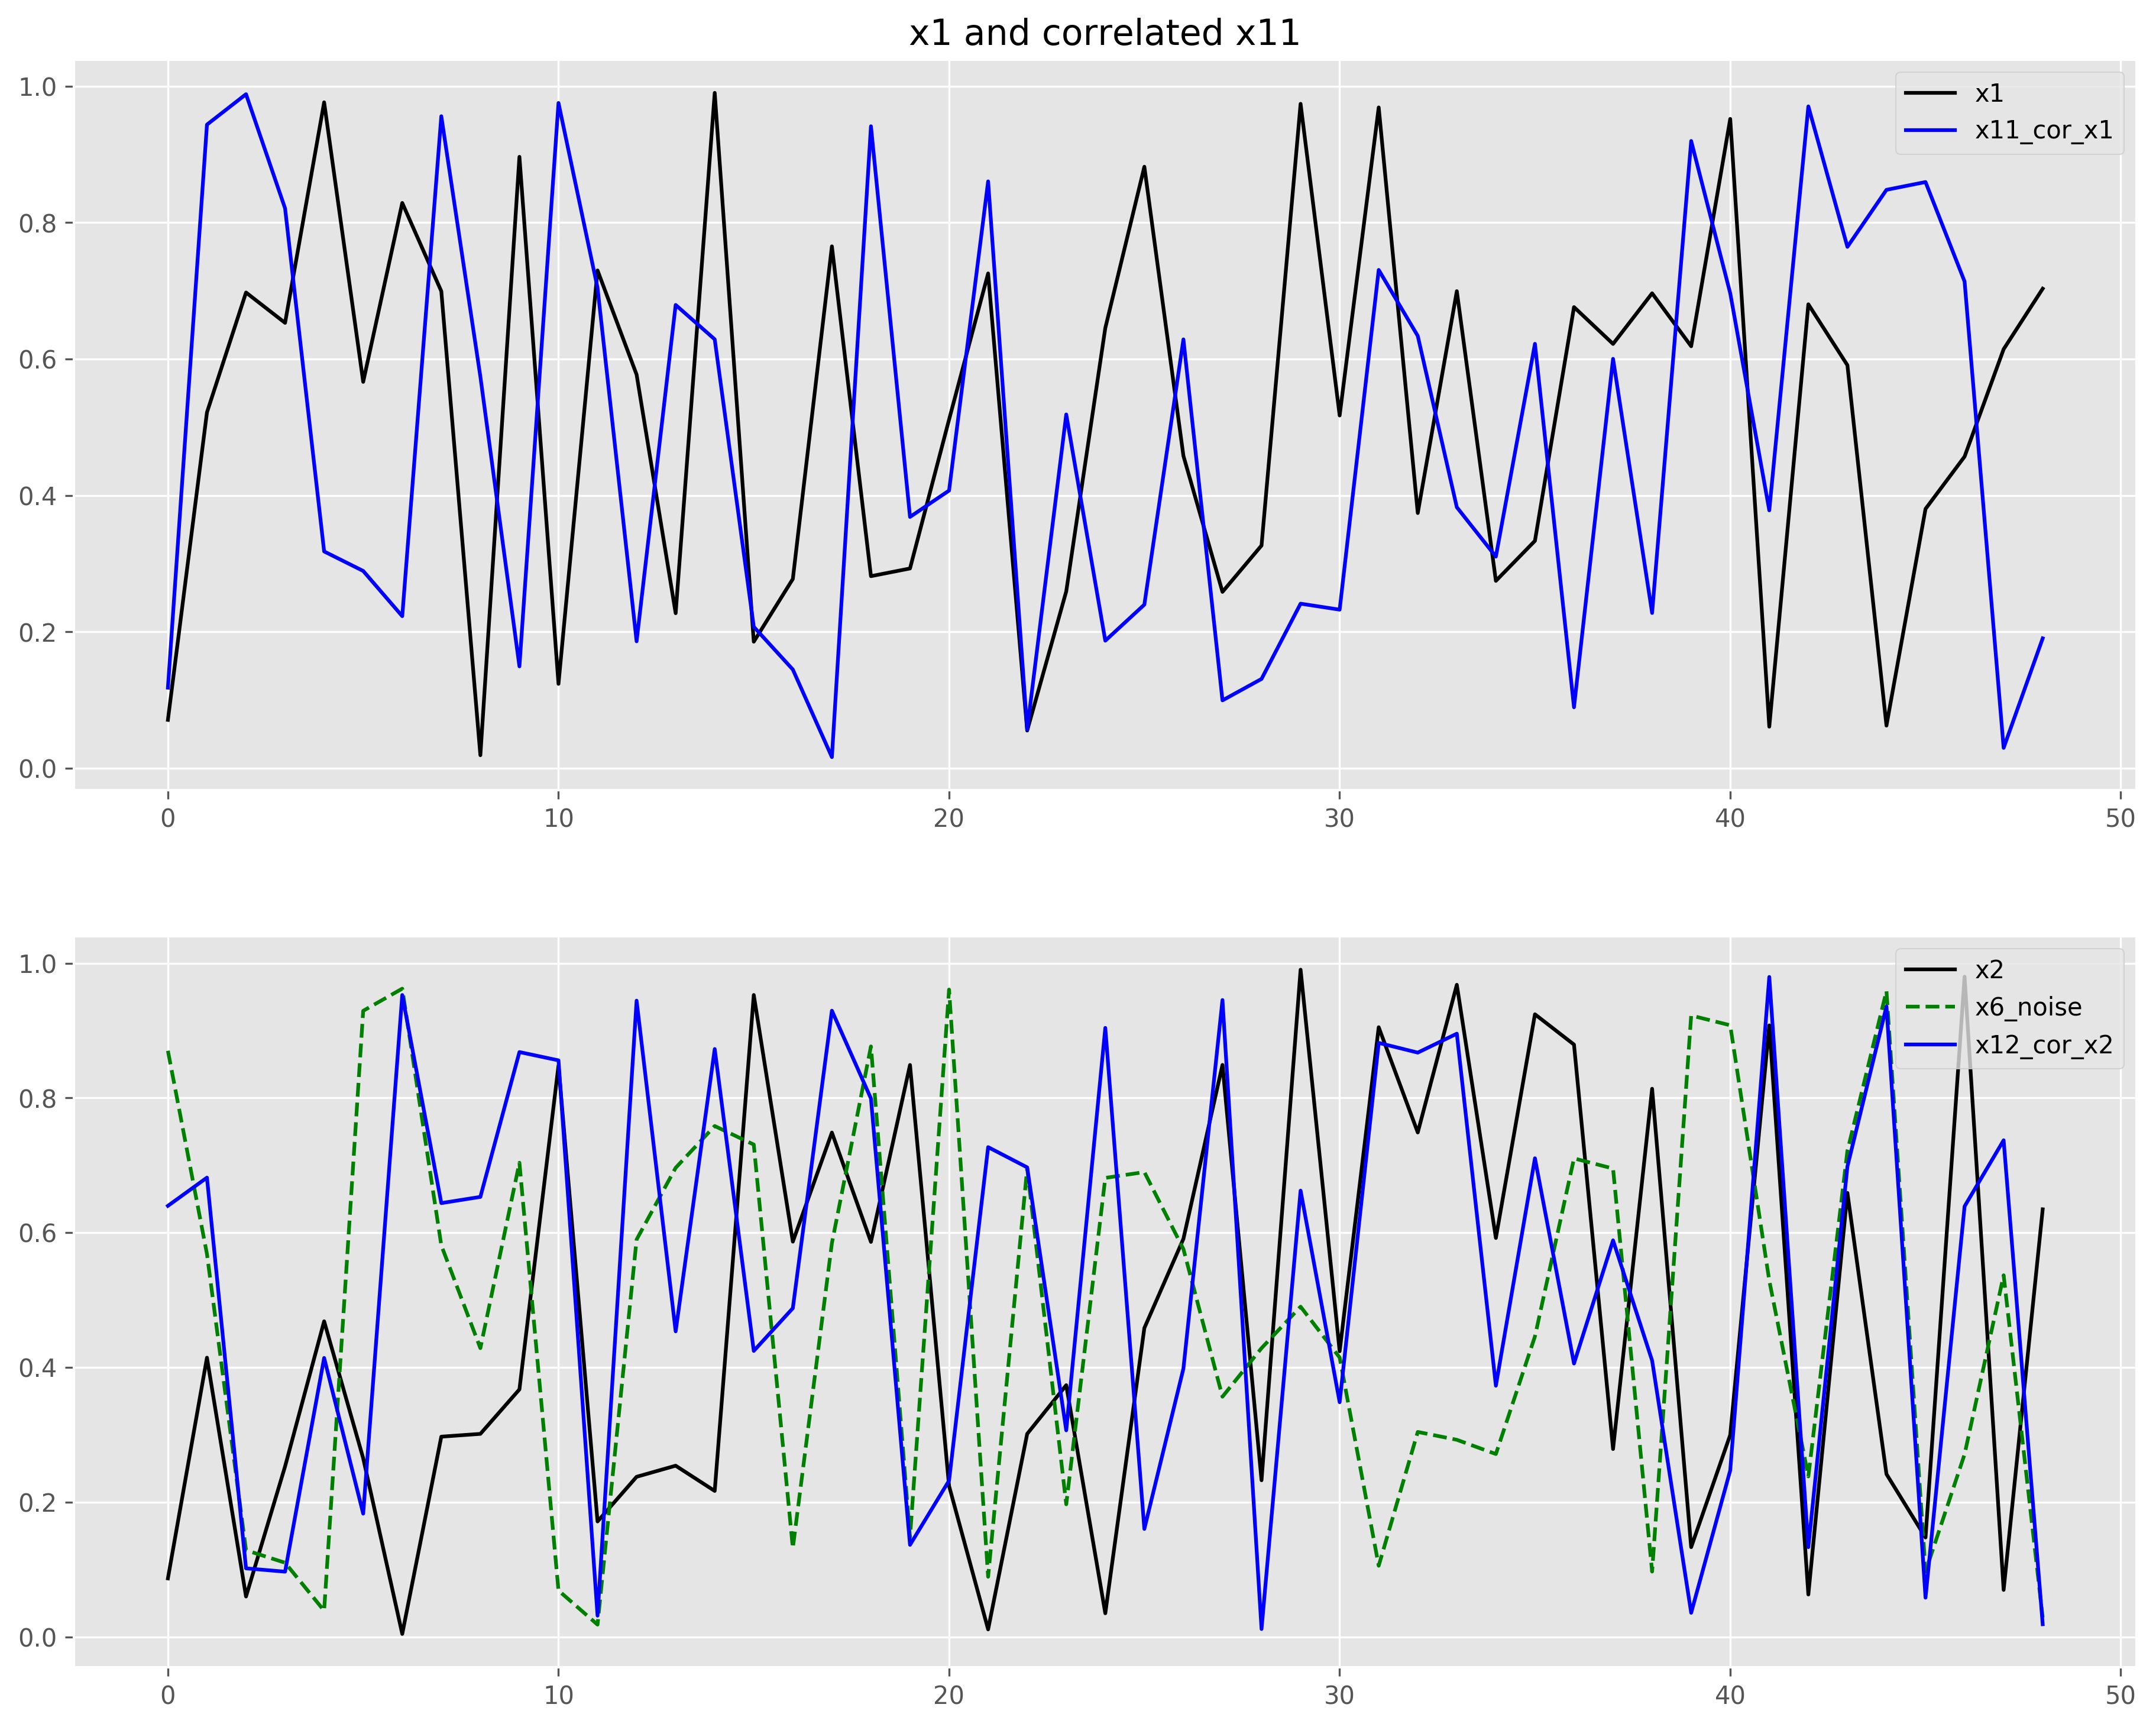

In [4]:
from sklearn.datasets import load_boston
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

size = 750
X = np.random.uniform(0,1,(size,14))

#"Friedamn #1" regressio problem
Y = (10 * np.sin(np.pi*X[:,0]*X[:,1]) + 20*(X[:,2] - .5)**2 +
     10*X[:,3] + 5*X[:,4] + np.random.normal(0,1))

# visualize the variables
plt.figure(1,figsize=(15,12),dpi=300)
plt.subplot(111)
plt.plot(Y,'k',label='Y')
plt.plot(X[:,0],'r',label='X1')
plt.legend(loc = 'best')

#plot normal, noisy and correlated variable
plt.figure(2,figsize=(15,12),dpi=300)
plt.subplot(211)
plt.plot(X[1:50,0],'k',label='x1');
plt.plot(X[1:50,10],'b',label='x11_cor_x1')
plt.title('x1 and correlated x11')
plt.legend(loc='best')
plt.subplot(212)
plt.plot(X[1:50,1],'k',label='x2')
plt.plot(X[1:50,5],'g--',label='x6_noise')
plt.plot(X[1:50,11],'b',label='x12_cor_x2')
plt.legend(loc='best')






In [5]:
# confirm the correlation between x_11 to x_15 with x_1..5
X[:,10:] = X[:,:4] + np.random.normal(0,0.025,(size,4))

for i in range(0,4):
    print("The correlation between variable %d and %d is %f:"%(i+1,i+11,np.corrcoef(X[:,i],X[:,10+i])[0,1]))
print("The correlation between variable x1 and x6 is %f"%(np.corrcoef(X[:,0],X[:,5])[0,1]))   


The correlation between variable 1 and 11 is 0.996147:
The correlation between variable 2 and 12 is 0.996337:
The correlation between variable 3 and 13 is 0.996623:
The correlation between variable 4 and 14 is 0.996200:
The correlation between variable x1 and x6 is -0.001091


In [6]:
#Add 3 additional correlated variables (correlated with X1-X3)

names = ["x%s" % i for i in range(1,15)]

ranks = {}

def rank_to_dict(ranks, names, order =1 ):
    mimax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

minmax = MinMaxScaler()


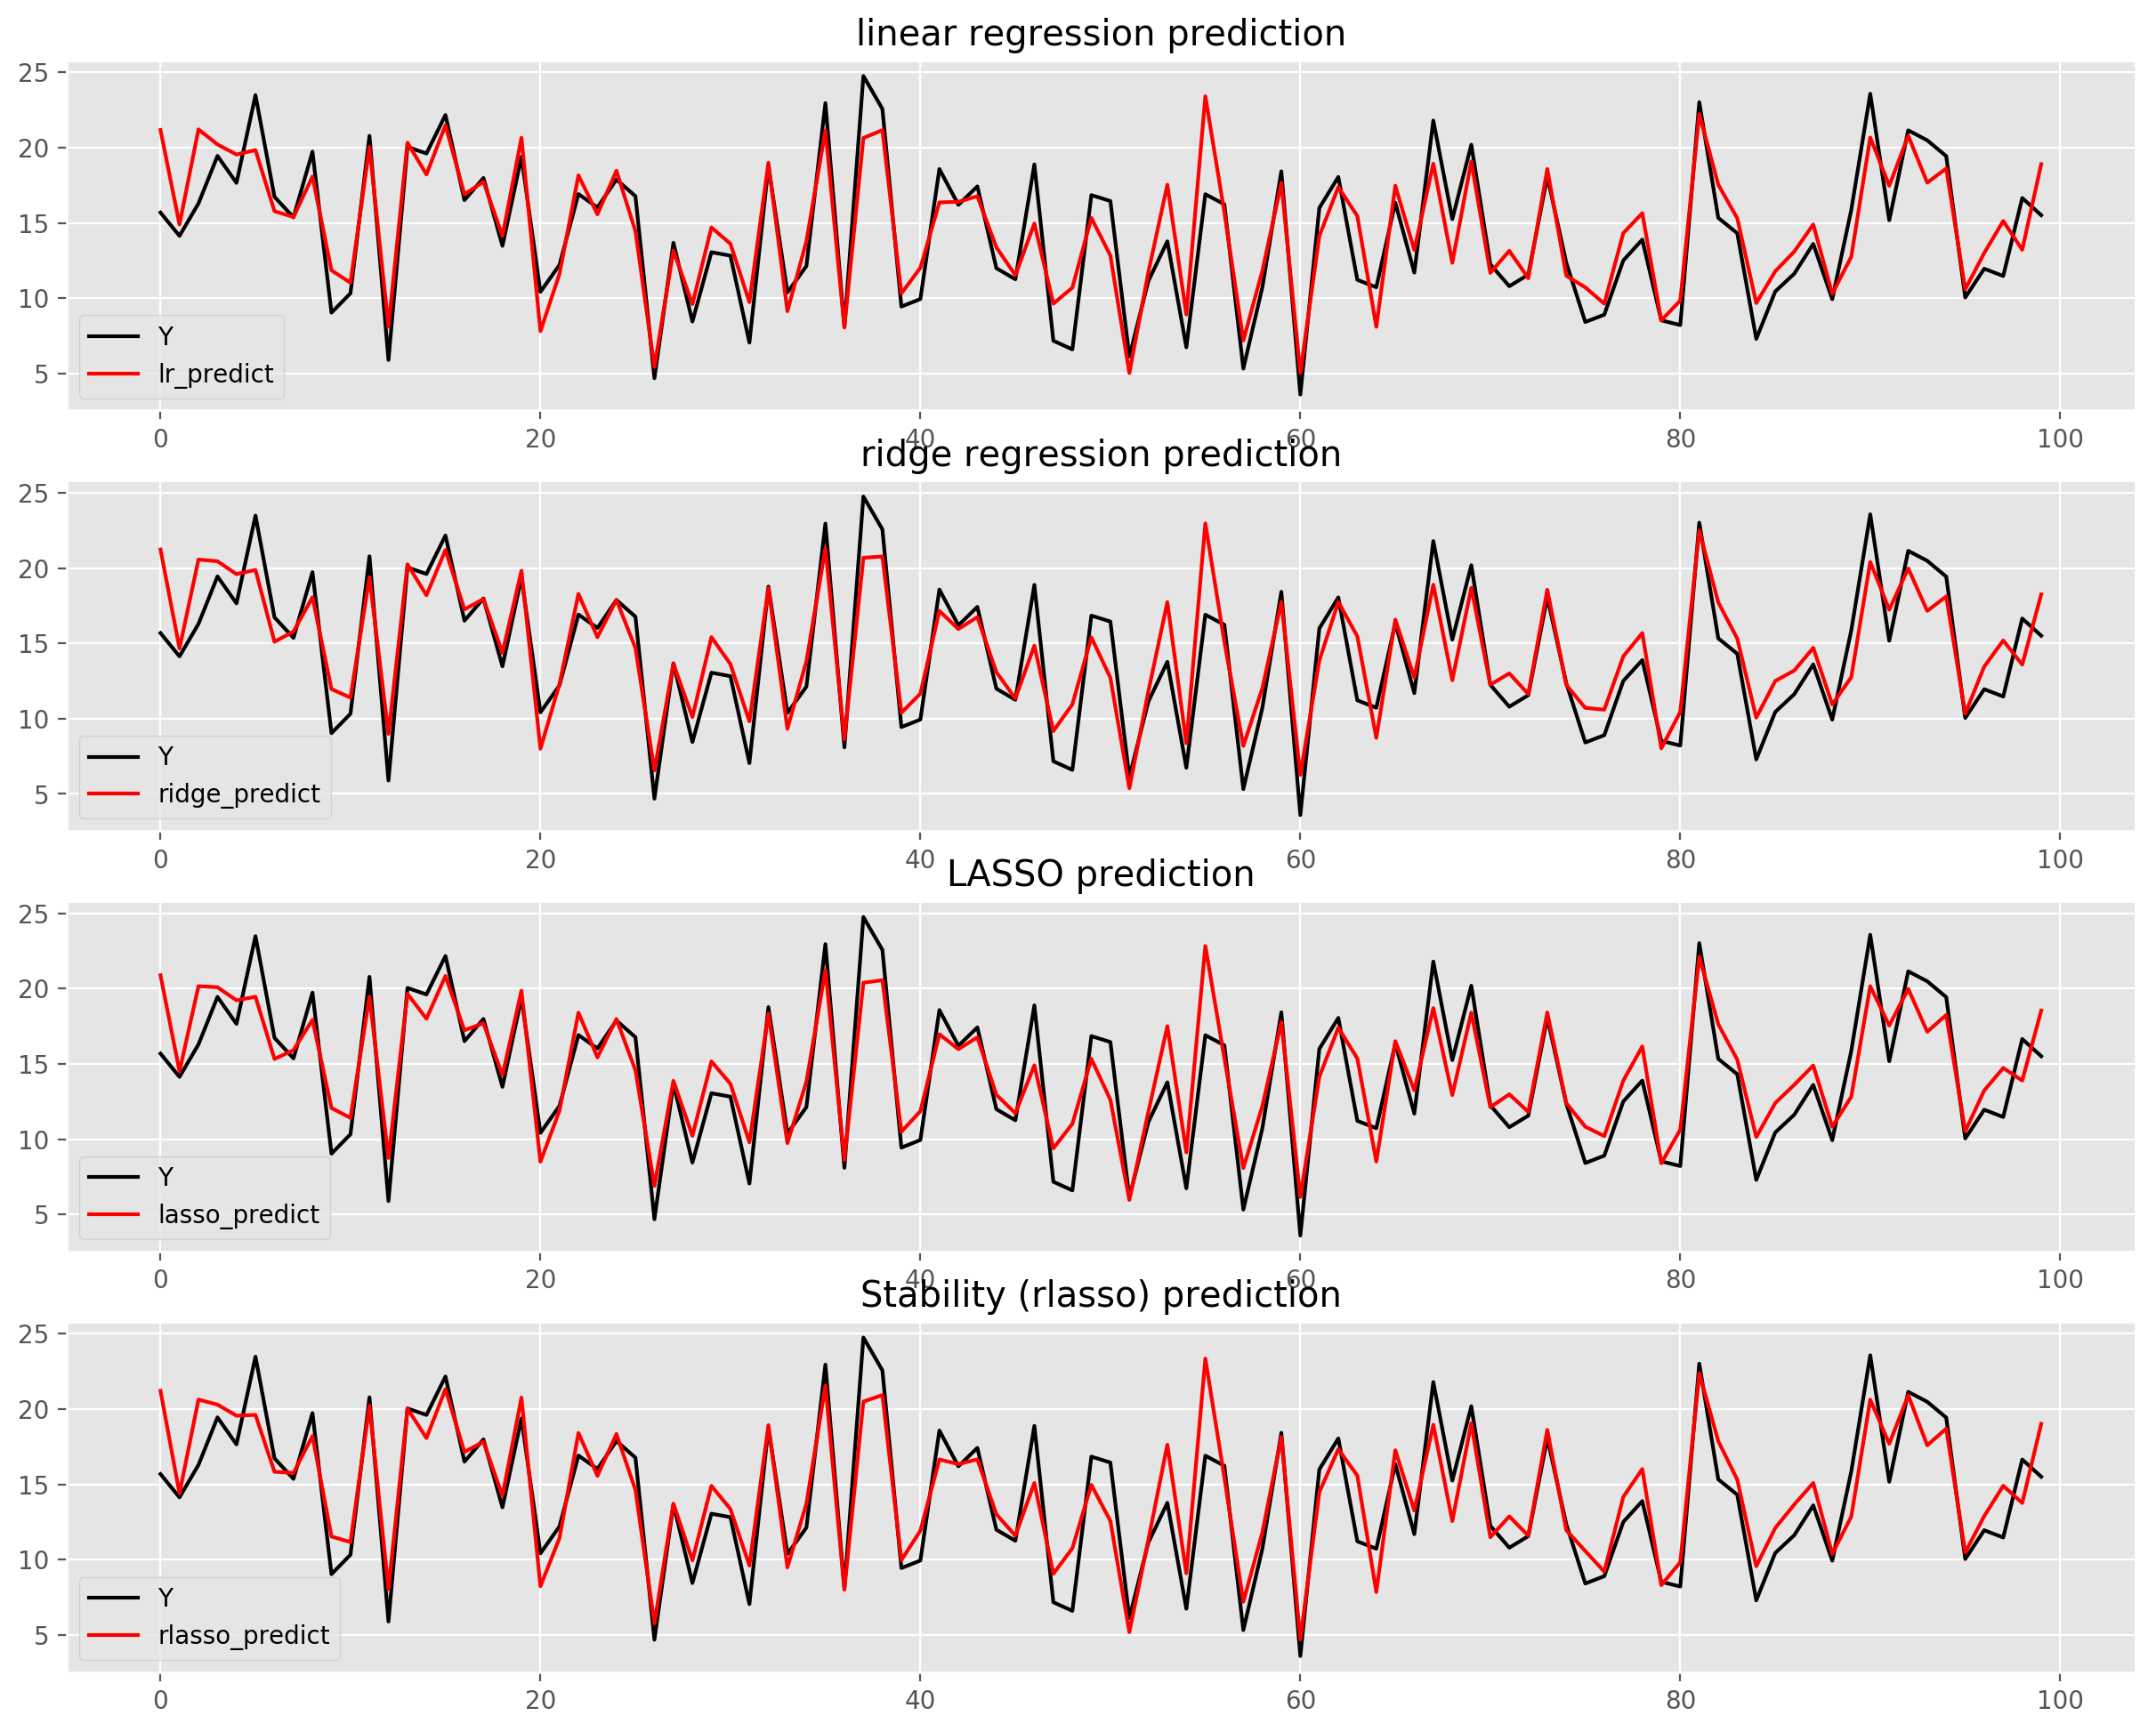

In [7]:
# linear regression
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["LReg"] = rank_to_dict(np.abs(lr.coef_), names)
#ridge regression
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)
#LASSO
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
#Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stabli"] = rank_to_dict(np.abs(rlasso.scores_), names)

pltrange = [600,700]
plt.figure(3,figsize=(15,12),dpi=200)
plt.subplot(411)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(lr.predict(X)[pltrange[0]:pltrange[1]],'r',label='lr_predict')
plt.legend(loc='best')
plt.title('linear regression prediction')

plt.subplot(412)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(ridge.predict(X)[pltrange[0]:pltrange[1]],'r',label='ridge_predict')
plt.legend(loc='best')
plt.title('ridge regression prediction')

plt.subplot(413)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(lasso.predict(X)[pltrange[0]:pltrange[1]],'r',label='lasso_predict')
plt.legend(loc='best')
plt.title('LASSO prediction')

# for rlasso need to transform the matrix
xtrans = rlasso.transform(X)
lrtf = LinearRegression(normalize = True)
lrtf.fit(xtrans,Y)
ypredict = lrtf.predict(xtrans)

plt.subplot(414)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(ypredict[pltrange[0]:pltrange[1]],'r',label='rlasso_predict')
plt.legend(loc='best')
plt.title('Stability (rlasso) prediction')




In [8]:
#stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(list(map(float, rfe.ranking_)), names, order=-1) 

# random forest
 
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)
 
[f, pval]  = f_regression(X, Y, center=True)
ranks["Corr."] = rank_to_dict(f, names)

#Maximal Information-based Nonparametric Exploration (MINE)
mine = MINE()
mic_scores = []
for i in range(X.shape[1]):
    mine.compute_score(X[:,i], Y)
    m = mine.mic()
    mic_scores.append(m)
    
    
ranks["MIC"] = rank_to_dict(mic_scores, names) 

In [9]:
X.shape

(750, 14)

In [10]:
from collections import OrderedDict
mic_rank = ranks['MIC']
mic_rank_ordered = OrderedDict(sorted(mic_rank.items(), key = lambda t:-t[1]))
#show ordered feature list
print(mic_rank_ordered)
selected_variables = list((mic_rank_ordered.keys()))[0:6]
idx =[int(item[1:])-1 for item in selected_variables]
feature_extracted_mine = X[0:X.shape[0],idx]
lr_MINE = LinearRegression(normalize = True)
lr_MINE.fit(feature_extracted_mine,Y)


OrderedDict([('x4', 1.0), ('x14', 1.0), ('x12', 0.70999999999999996), ('x2', 0.60999999999999999), ('x11', 0.42999999999999999), ('x1', 0.39000000000000001), ('x3', 0.34000000000000002), ('x13', 0.23000000000000001), ('x5', 0.20000000000000001), ('x9', 0.089999999999999997), ('x7', 0.070000000000000007), ('x8', 0.050000000000000003), ('x10', 0.040000000000000001), ('x6', 0.0)])


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

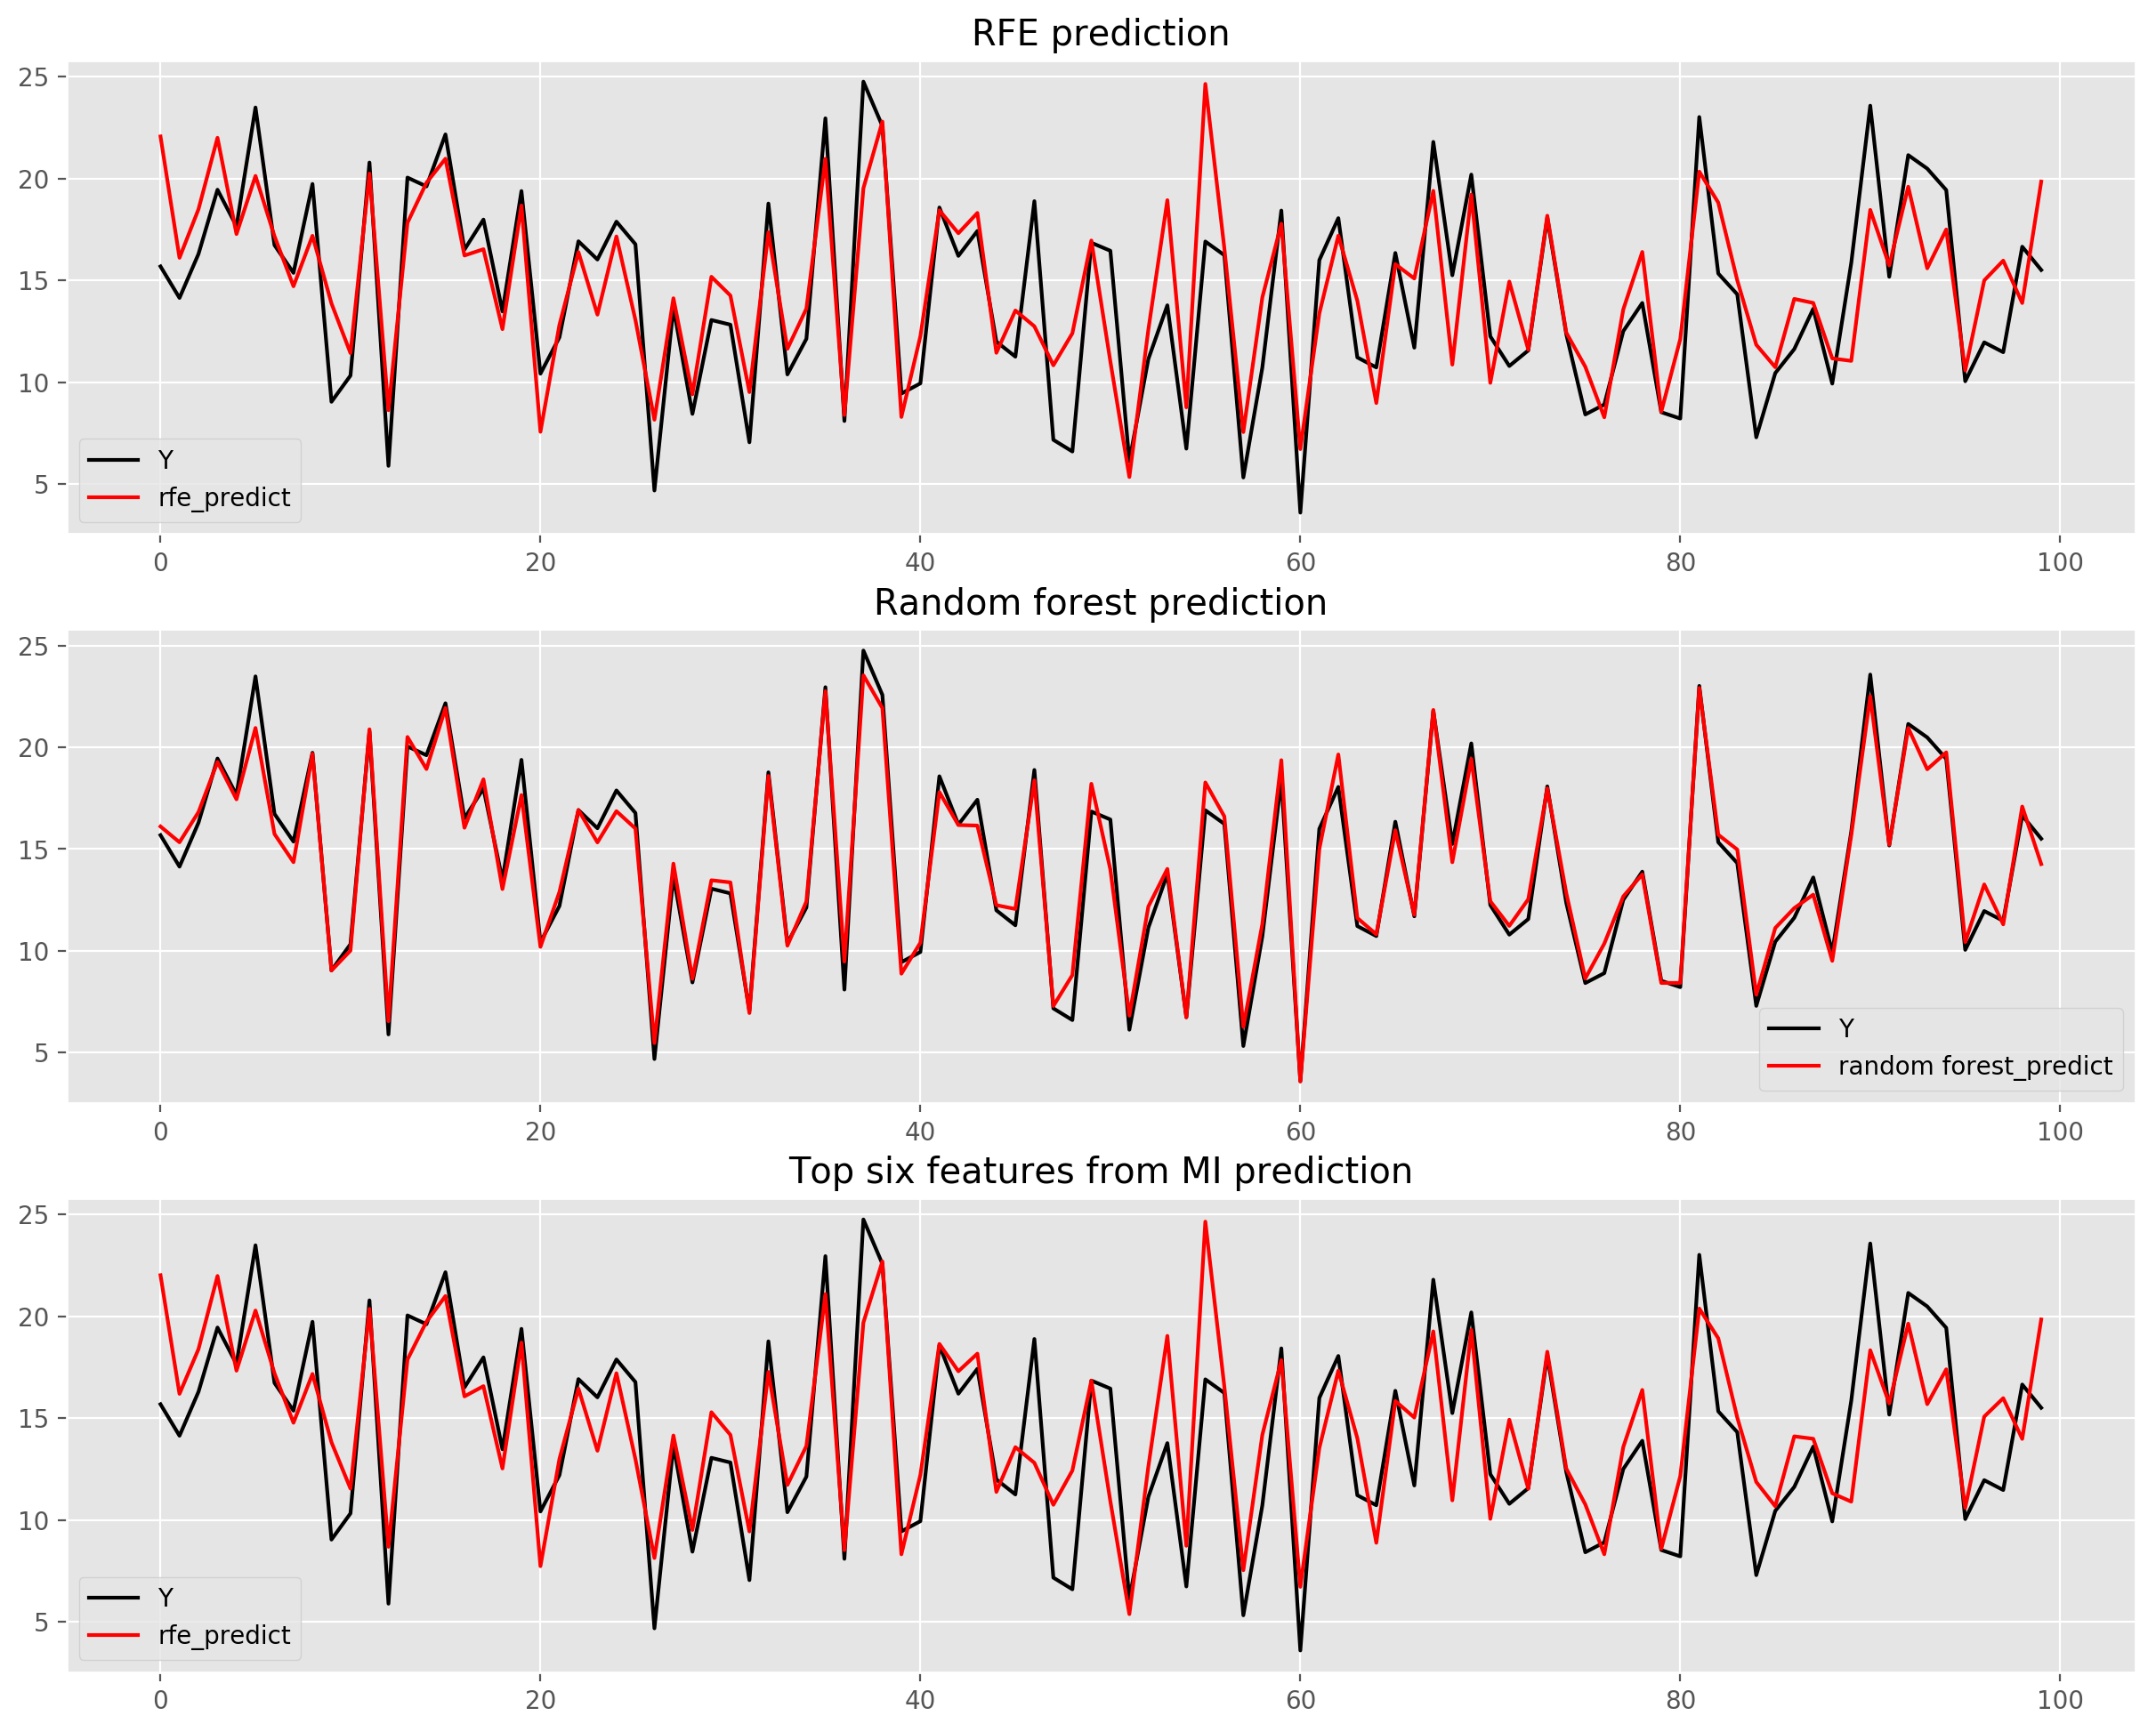

In [11]:
plt.figure(4,figsize=(15,12),dpi=200)
plt.subplot(311)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(rfe.predict(X)[pltrange[0]:pltrange[1]],'r',label='rfe_predict')
plt.legend(loc='best')
plt.title('RFE prediction')

plt.subplot(312)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(rf.predict(X)[pltrange[0]:pltrange[1]],'r',label='random forest_predict')
plt.legend(loc='best')
plt.title('Random forest prediction')

plt.subplot(313)
plt.plot(Y[pltrange[0]:pltrange[1]],'k',label='Y')
plt.plot(lr_MINE.predict(feature_extracted_mine)[pltrange[0]:pltrange[1]],'r',label='rfe_predict')
plt.legend(loc='best')
plt.title('Top six features from MI prediction')



In [12]:

 
r = {} 

for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)    
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")


In [13]:
print ("\t%s" % "\t".join(methods))
for name in names:
    print ("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Corr.	LReg	Lasso	MIC	RF	RFE	Ridge	Stabli	Mean
x1	0.3	1.0	0.79	0.39	0.55	1.0	0.77	0.77	0.7
x2	0.44	0.56	0.83	0.61	0.67	1.0	0.75	0.72	0.7
x3	0.0	0.5	0.0	0.34	0.13	1.0	0.05	0.0	0.25
x4	1.0	0.57	1.0	1.0	0.56	1.0	1.0	1.0	0.89
x5	0.1	0.27	0.51	0.2	0.29	0.78	0.88	0.55	0.45
x6	0.0	0.02	0.0	0.0	0.01	0.44	0.05	0.0	0.06
x7	0.01	0.0	0.0	0.07	0.02	0.0	0.01	0.0	0.01
x8	0.02	0.03	0.0	0.05	0.01	0.56	0.09	0.0	0.1
x9	0.01	0.0	0.0	0.09	0.01	0.11	0.0	0.0	0.03
x10	0.0	0.01	0.0	0.04	0.0	0.33	0.01	0.0	0.05
x11	0.29	0.6	0.0	0.43	0.39	1.0	0.59	0.37	0.46
x12	0.44	0.14	0.0	0.71	0.35	0.67	0.68	0.46	0.43
x13	0.0	0.48	0.0	0.23	0.07	0.89	0.02	0.0	0.21
x14	0.99	0.0	0.16	1.0	1.0	0.22	0.95	0.62	0.62


The example should highlight some the interesting characteristics of the different methods.

With **linear correlation (Lin. corr.)**, each feature is evaluated independently, so the scores for features x1…x4 are very similar to x11…x14, while the noise features x5…x10 are correctly identified to have almost no relation with the response variable. It’s not able to identify any relationship between x3 and the response variable, since the relationship is quadratic (in fact, this applies almost all other methods except for MIC). It’s also clear that while the method is able to measure the linear relationship between each feature and the response variable, it is not optimal for selecting the top performing features for improving the generalization of a model, since all top performing features would essentially be picked twice.

**Lasso** picks out the top performing features, while forcing other features to be close to zero. It is clearly useful when reducing the number of features is required, but not necessarily for data interpretation (since it might lead one to believe that features x11…x13 do not have a strong relationship with the output variable).

**MIC** is similar to correlation coefficient in treating all features “equally”, additionally it is able to find the non-linear a relationship between x3 and the response.

**Random forest**’s impurity based ranking is typically aggressive in the sense that there is a sharp drop-off of scores after the first few top ones. This can be seen from the example where the third ranked feature has already 4x smaller score than the top feature (whereas for the other ranking methods, the drop-off is clearly not that aggressive).

**Ridge regression** forces regressions coefficients to spread out similarly between correlated variables. This is clearly visible in the example where x11…x14 are close to x1…x4 in terms of scores.

**Stability selection** is often able to make a useful compromise between data interpretation and top feature selection for model improvement. This is illustrated well in the example. Just like Lasso it is able to identify the top features (x1, x2, x4, x5). At the same time their correlated shadow variables also get a high score, illustrating their relation with the response.

Conclusions

Feature ranking can be incredibly useful in a number of machine learning and data mining scenarios. The key though is to have the end goal clearly in mind and understand which method works best for achieving it. When selecting top features for model performance improvement, it is easy to verify if a particular method works well against alternatives simply by doing cross-validation. It’s not as straightforward when using feature ranking for data interpretation, where stability of the ranking method is crucial and a method that doesn’t have this property (such as lasso) could easily lead to incorrect conclusions. What can help there is subsampling the data and running the selection algorithms on the subsets. If the results are consistent across the subsets, it is relatively safe to trust the stability of the method on this particular data and therefor straightforward to interpret the data in terms of the ranking.